In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.nn.modules.batchnorm import BatchNorm1d

In [3]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 40330108.59it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


In [6]:
for batch in train_loader:
  batch_images, batch_labels = batch
  break
batch_images.shape

torch.Size([64, 3, 32, 32])

Значит, каждое изображение имеет размер 32х32 и три канала цвета. Следовательно, входной одномерный вектор будет иметь 32х32х3 числа.

Заведем функцию для отрисовки изображения:

In [11]:
def show_images(images, labels):
  for i in range(min(len(images), 5)):
    img = images[i].numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title(labels[i].numpy())
    plt.show()

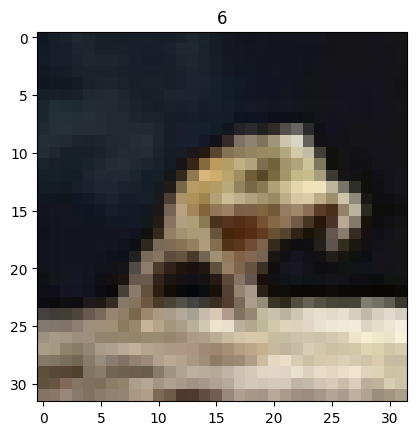

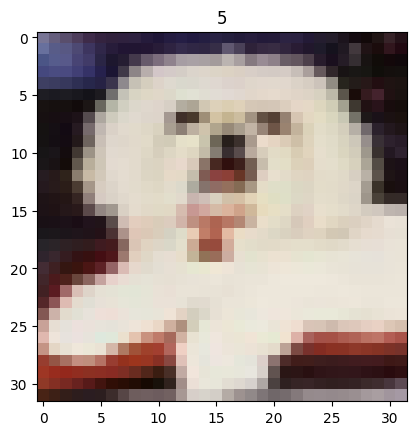

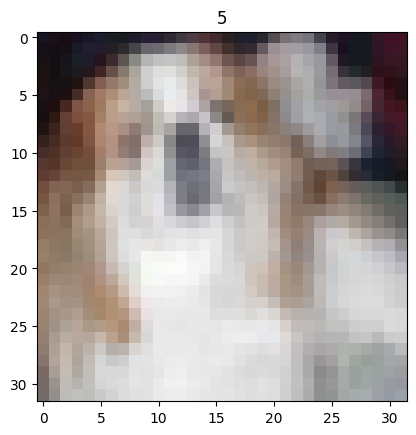

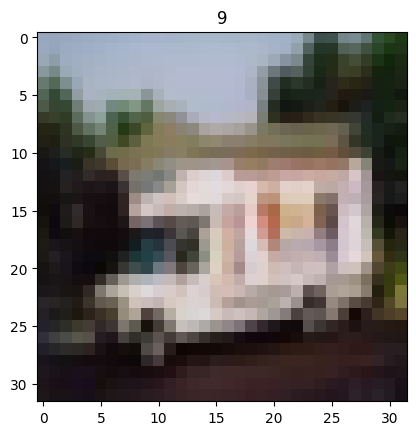

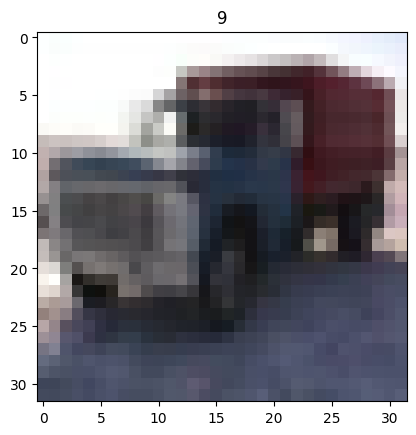

In [12]:
for batch in train_loader:
  images, labels = batch
  break

show_images(images, labels)

In [67]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(32*32*3, 512)
    self.ac1 = nn.ReLU()
    self.bn1 = BatchNorm1d(512)

    self.fc2 = nn.Linear(512, 256)
    self.ac2 = nn.ReLU()
    self.bn2 = BatchNorm1d(256)

    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.flatten(x)

    x = self.ac1(self.fc1(x))
    x = self.bn1(x)

    x = self.ac2(self.fc2(x))
    x = self.bn2(x)

    return self.fc3(x)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:
model = Model().to(device)

In [17]:
from sklearn.metrics import accuracy_score


def evaluate(model, dataloader, criterion):
  y_pred_list = []
  y_true_list = []
  losses = []
  for i, batch in enumerate(dataloader):
    X_batch, y_batch = batch

    with torch.no_grad():

      y_pred = model(X_batch.to(device))

      loss = criterion(y_pred, y_batch.to(device))
      loss = loss.item()
      losses.append(loss)

      y_pred = torch.argmax(y_pred, dim=1)

    y_pred_list.extend(y_pred.cpu().numpy())
    y_true_list.extend(y_batch.numpy())
  acc = accuracy_score(y_pred_list, y_true_list)
  return acc, np.mean(losses)

In [18]:
def train(model, criterion, optimizer, n_epoch):
  data = {
      'acc_train' : [],
      'loss_train' : [],
      'acc_val' : [],
      'loss_val' : []
  }
  for epoch in tqdm(range(n_epoch)):
    for i, batch in enumerate(train_loader):
      X_batch, y_batch = batch
      y_pred = model(X_batch.to(device))
      loss = criterion(y_pred, y_batch.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    acc_train, loss_train = evaluate(model, train_loader, criterion)
    acc_val, loss_val = evaluate(model, val_loader, criterion)

    data['acc_train'].append(acc_train)
    data['loss_train'].append(loss_train)
    data['acc_val'].append(acc_val)
    data['loss_val'].append(loss_val)
  return model, data

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model, data = train(model, criterion, optimizer, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

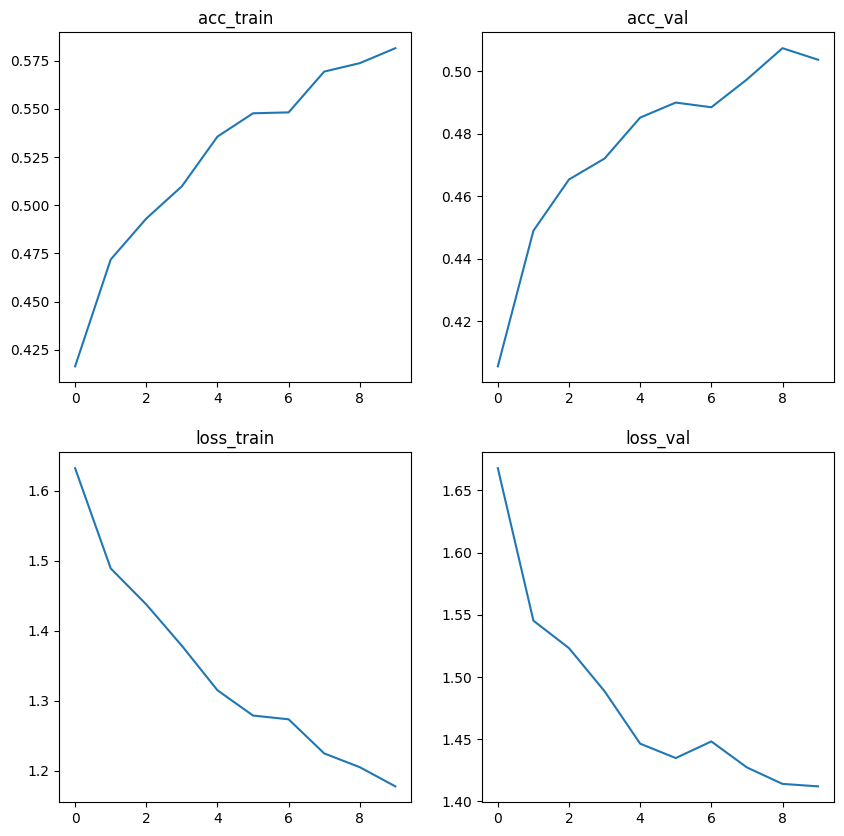

In [70]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ox = list(range(10))

axes[0][0].plot(ox, data['acc_train'])
axes[0][0].title.set_text('acc_train')

axes[0][1].plot(ox, data['acc_val'])
axes[0][1].title.set_text('acc_val')

axes[1][0].plot(ox, data['loss_train'])
axes[1][0].title.set_text('loss_train')

axes[1][1].plot(ox, data['loss_val'])
axes[1][1].title.set_text('loss_val')

plt.show()

In [71]:
test_acc, test_loss = evaluate(model, test_loader, criterion)
test_acc

0.5143